Лабораторная работа №6. Настройка рекуррентной нейросети для исследования сигналов
Цель работы – написать программу на языке Python, выполняющую построение и обучение модели прогнозирования будущих значений на основе данных временной последовательности (выборка получена от преподавателя), требуется подобрать архитектуру рекуррентной нейронной сети, работающей с допустимым уровнем ошибки и визуализировать процесс обучения моделей и привести метрики качества. Результаты работы привести в отчете.

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

1) Установка библиотек и подготовка окружения

numpy и pandas используются для работы с данными.
keras предоставляет инструменты для создания и обучения нейронных сетей.
MinMaxScaler масштабирует данные для улучшения обучения модели.
Метрики mean_squared_error и mean_absolute_error будут использоваться для оценки модели.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


2) Загрузка данных https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

Данные о температуре загружаются и масштабируются для нормализации значений.
Пропущенные значения удаляются, чтобы избежать ошибок в обучении.

In [3]:
# Загрузка данных
file_path = "/kaggle/input/historical-hourly-weather-data/temperature.csv"
df = pd.read_csv(file_path)

# Предварительный просмотр данных
print(df.head())

# Выбор данных для одного города
df = df[['datetime', 'Seattle']]

# Проверка на наличие пропущенных значений и их удаление
df = df.dropna()

# Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
data = df['Seattle'].values.reshape(-1, 1)
data_scaled = scaler.fit_transform(data)


              datetime   Vancouver    Portland  San Francisco     Seattle  \
0  2012-10-01 12:00:00         NaN         NaN            NaN         NaN   
1  2012-10-01 13:00:00  284.630000  282.080000     289.480000  281.800000   
2  2012-10-01 14:00:00  284.629041  282.083252     289.474993  281.797217   
3  2012-10-01 15:00:00  284.626998  282.091866     289.460618  281.789833   
4  2012-10-01 16:00:00  284.624955  282.100481     289.446243  281.782449   

   Los Angeles   San Diego   Las Vegas     Phoenix  Albuquerque  ...  \
0          NaN         NaN         NaN         NaN          NaN  ...   
1   291.870000  291.530000  293.410000  296.600000   285.120000  ...   
2   291.868186  291.533501  293.403141  296.608509   285.154558  ...   
3   291.862844  291.543355  293.392177  296.631487   285.233952  ...   
4   291.857503  291.553209  293.381213  296.654466   285.313345  ...   

   Philadelphia    New York    Montreal      Boston   Beersheba  \
0           NaN         NaN         N

3) Формирование обучающей и тестовой выборки

Функция create_dataset создает обучающие выборки на основе скользящего окна, что помогает модели обучаться предсказывать значения.
Данные разделены на обучающую и тестовую выборку, чтобы оценить качество модели на тестовых данных.

In [4]:
def create_dataset(data, window_size):
    # Формируем выборки X и y из последовательных окон данных
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        # Каждое окно длиной window_size добавляется в X
        X.append(data[i:(i + window_size), 0])
        # Следующее значение после окна добавляется в y как целевая переменная
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 20  # Длина окна для временного ряда
X, y = create_dataset(data_scaled, window_size)  # Создаем X и y с указанным размером окна

# Разделение данных на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразуем X для RNN: добавляем измерение для признаков
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


4) Построение модели простой RNN

Модель SimpleRNN состоит из одного слоя с 32 нейронами.
Функция активации relu используется для нелинейных преобразований.

In [5]:
def build_simple_rnn(input_shape):
    # Создаем последовательную модель RNN
    model = Sequential()
    # Добавляем слой SimpleRNN с 32 нейронами и активацией ReLU
    model.add(SimpleRNN(32, input_shape=input_shape, activation='relu'))
    # Добавляем полносвязный слой с одним выходом для предсказания
    model.add(Dense(1))
    # Компилируем модель с оптимизатором Adam и функцией потерь MSE
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


# Построение модели
model_rnn = build_simple_rnn((window_size, 1))

# Обучение модели
history_rnn = model_rnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


905/905 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0035 - mean_absolute_error: 0.0326 - val_loss: 3.5222e-04 - val_mean_absolute_error: 0.0128
Epoch 2/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.6638e-04 - mean_absolute_error: 0.0134 - val_loss: 3.2087e-04 - val_mean_absolute_error: 0.0123
Epoch 3/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.2260e-04 - mean_absolute_error: 0.0125 - val_loss: 3.9991e-04 - val_mean_absolute_error: 0.0146
Epoch 4/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.2520e-04 - mean_absolute_error: 0.0124 - val_loss: 3.0359e-04 - val_mean_absolute_error: 0.0116
Epoch 5/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.1203e-04 - mean_absolute_error: 0.0121 - val_loss: 3.0744e-04 - val_mean_absolute_error: 0.0118
Epoch 6/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.3224e-04 - mean_absolute_error: 0.0124 - val_loss: 3.1775e-04 - val_mean_absolute_error: 0.0122
Epoch 7/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.4865e

5) Построение модели LSTM
LSTM позволяет учитывать долгосрочные зависимости в данных, что делает её эффективной для временных рядов.
Модель обучается аналогично простой RNN, но с использованием более сложной архитектуры LSTM.

In [6]:
def build_lstm(input_shape):
    # Создаем последовательную модель LSTM
    model = Sequential()
    # Добавляем слой LSTM с 128 нейронами, используя переданную форму входных данных
    model.add(LSTM(128, input_shape=input_shape))
    # Добавляем полносвязный слой с одним выходом для предсказания
    model.add(Dense(1))
    # Компилируем модель с оптимизатором Adam и функцией потерь MSE
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


# Построение модели
model_lstm = build_lstm((window_size, 1))

# Обучение модели
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.0094 - mean_absolute_error: 0.0572 - val_loss: 7.6485e-04 - val_mean_absolute_error: 0.0209
Epoch 2/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 6.6765e-04 - mean_absolute_error: 0.0194 - val_loss: 4.1825e-04 - val_mean_absolute_error: 0.0143
Epoch 3/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 4.6867e-04 - mean_absolute_error: 0.0155 - val_loss: 3.6353e-04 - val_mean_absolute_error: 0.0132
Epoch 4/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 4.0095e-04 - mean_absolute_error: 0.0141 - val_loss: 3.7533e-04 - val_mean_absolute_error: 0.0135
Epoch 5/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 3.7218e-04 - mean_absolute_error: 0.0134 - val_loss: 3.1013e-04 - val_mean_absolute_error: 0.0118
Epoch 6/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 3.3625e-04 - mean_absolute_error: 0.0127 - val_loss: 2.9462e-04 - val_mean_absolute_error: 0.0112
Epoch 7/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 20s 

6) Построение стека LSTM

В стек LSTM входит несколько слоев LSTM для более глубокого обучения. Это может улучшить качество модели на сложных данных.
Архитектура аналогична модели LSTM, но с дополнительным слоем.

In [7]:
def build_stacked_lstm(input_shape):
    # Создаем последовательную модель со слоями LSTM
    model = Sequential()
    # Первый LSTM слой возвращает последовательности для следующего слоя
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    # Второй LSTM слой без возврата последовательностей
    model.add(LSTM(50))
    # Добавляем полносвязный выходной слой с одним нейроном
    model.add(Dense(1))
    # Компилируем модель с оптимизатором Adam и функцией потерь MSE
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


# Построение модели
model_stacked_lstm = build_stacked_lstm((window_size, 1))

# Обучение модели
history_stacked_lstm = model_stacked_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0080 - mean_absolute_error: 0.0577 - val_loss: 6.6507e-04 - val_mean_absolute_error: 0.0189
Epoch 2/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 6.6946e-04 - mean_absolute_error: 0.0192 - val_loss: 4.2140e-04 - val_mean_absolute_error: 0.0146
Epoch 3/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 4.2551e-04 - mean_absolute_error: 0.0149 - val_loss: 3.4886e-04 - val_mean_absolute_error: 0.0130
Epoch 4/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 3.5733e-04 - mean_absolute_error: 0.0132 - val_loss: 3.6027e-04 - val_mean_absolute_error: 0.0135
Epoch 5/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 3.3828e-04 - mean_absolute_error: 0.0127 - val_loss: 3.0243e-04 - val_mean_absolute_error: 0.0118
Epoch 6/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 3.6304e-04 - mean_absolute_error: 0.0130 - val_loss: 3.3406e-04 - val_mean_absolute_error: 0.0128
Epoch 7/20
905/905 ━━━━━━━━━━━━━━━━━━━━ 17s 

7) Оценка качества модели

Визуализация потерь для каждой модели показывает динамику их обучения. На графиках можно увидеть момент переобучения.
Итоговые значения метрик позволяют сравнить модели по точности на тестовых данных.

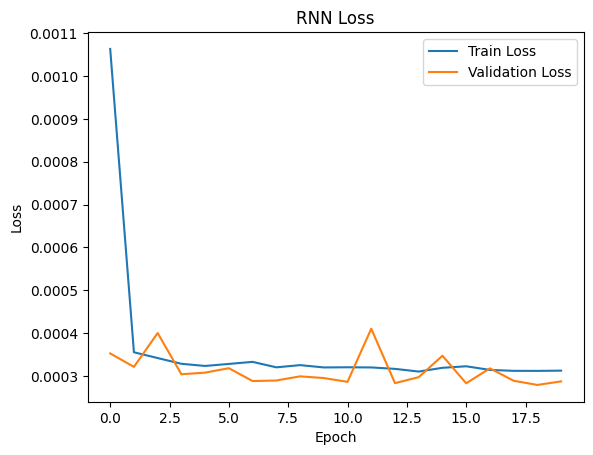

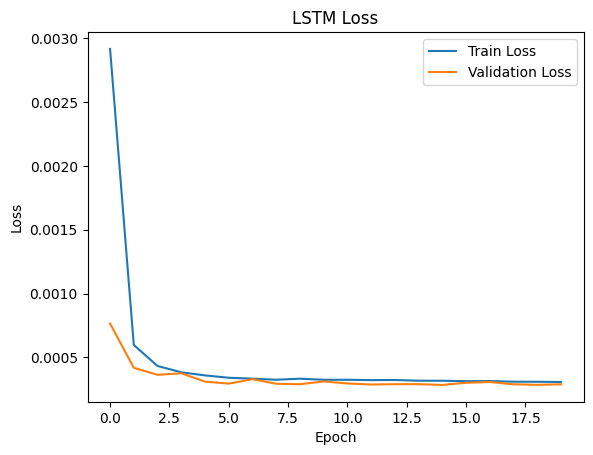

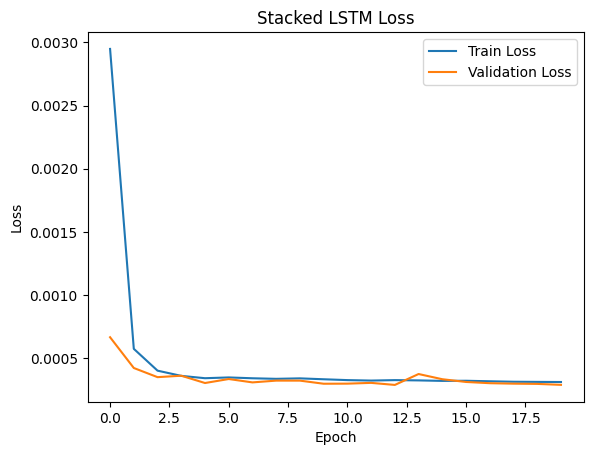

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9443e-04 - mean_absolute_error: 0.0113
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.9255e-04 - mean_absolute_error: 0.0114
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.8988e-04 - mean_absolute_error: 0.0115


In [8]:
# Функция для построения графика потерь
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Train Loss')  # График потерь на обучающих данных
    plt.plot(history.history['val_loss'], label='Validation Loss')  # График потерь на валидационных данных
    plt.title(title)  # Заголовок графика
    plt.xlabel('Epoch')  
    plt.ylabel('Loss')
    plt.legend()  
    plt.show() 


# Визуализация процесса обучения для всех моделей
plot_loss(history_rnn, 'RNN Loss')  # Визуализация потерь для RNN
plot_loss(history_lstm, 'LSTM Loss')  # Визуализация потерь для LSTM
plot_loss(history_stacked_lstm, 'Stacked LSTM Loss')  # Визуализация потерь для Stacked LSTM


# Оценка модели на тестовых данных
test_loss_rnn = model_rnn.evaluate(X_test, y_test)  # Оценка RNN на тестовых данных
test_loss_lstm = model_lstm.evaluate(X_test, y_test)  # Оценка LSTM на тестовых данных
test_loss_stacked_lstm = model_stacked_lstm.evaluate(X_test, y_test)  # Оценка Stacked LSTM на тестовых данных



8) Создание функции для вывода ошибок
Функция print_error, которая будет рассчитывать и выводить метрики средней абсолютной ошибки MAE и  средней квадратичной ошибки MSE для обучающей и тестовой выборок:

In [9]:
def print_error(trainY, testY, train_predict, test_predict):
    # Ошибки на обучающей выборке
    mae_train = mean_absolute_error(trainY, train_predict)
    mse_train = mean_squared_error(trainY, train_predict)
    print('Train MAE: %.10f' % mae_train)
    print('Train MSE: %.10f' % mse_train)

    # Ошибки на тестовой выборке
    mae_test = mean_absolute_error(testY, test_predict)
    mse_test = mean_squared_error(testY, test_predict)
    print('Test MAE: %.10f' % mae_test)
    print('Test MSE: %.10f' % mse_test)


9) Получение предсказаний для всех моделей
Предсказания для обучающих и тестовых данных каждой модели

In [10]:
# Предсказания на обучающих и тестовых данных для всех моделей
train_predict_rnn = model_rnn.predict(X_train)
test_predict_rnn = model_rnn.predict(X_test)

train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

train_predict_stacked_lstm = model_stacked_lstm.predict(X_train)
test_predict_stacked_lstm = model_stacked_lstm.predict(X_test)


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


10) Вывод ошибок для каждой модели

In [11]:
print("RNN Model:")
print_error(y_train, y_test, train_predict_rnn, test_predict_rnn)

print("\nLSTM Model:")
print_error(y_train, y_test, train_predict_lstm, test_predict_lstm)

print("\nStacked LSTM Model:")
print_error(y_train, y_test, train_predict_stacked_lstm, test_predict_stacked_lstm)


RNN Model:
Train MAE: 0.0114284060
Train MSE: 0.0002945363
Test MAE: 0.0113928035
Test MSE: 0.0002917595

LSTM Model:
Train MAE: 0.0114637493
Train MSE: 0.0002981363
Test MAE: 0.0114149651
Test MSE: 0.0002912317

Stacked LSTM Model:
Train MAE: 0.0115634954
Train MSE: 0.0002949944
Test MAE: 0.0115418677
Test MSE: 0.0002891168


11) Создание функции для визуализации предсказаний
Функция plot_result, которая будет визуализировать предсказания в сравнении с реальными данными

In [12]:
def plot_result(testY, predictions, title):
    plt.figure(figsize=(15, 6), dpi=100)
    plt.plot(testY, label='Реальная температура')
    plt.plot(predictions, label='Предсказания')
    plt.legend()
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Отмасштабированная температура')
    plt.title(title)
    plt.show()


12) Визуализация предсказаний для каждой модели

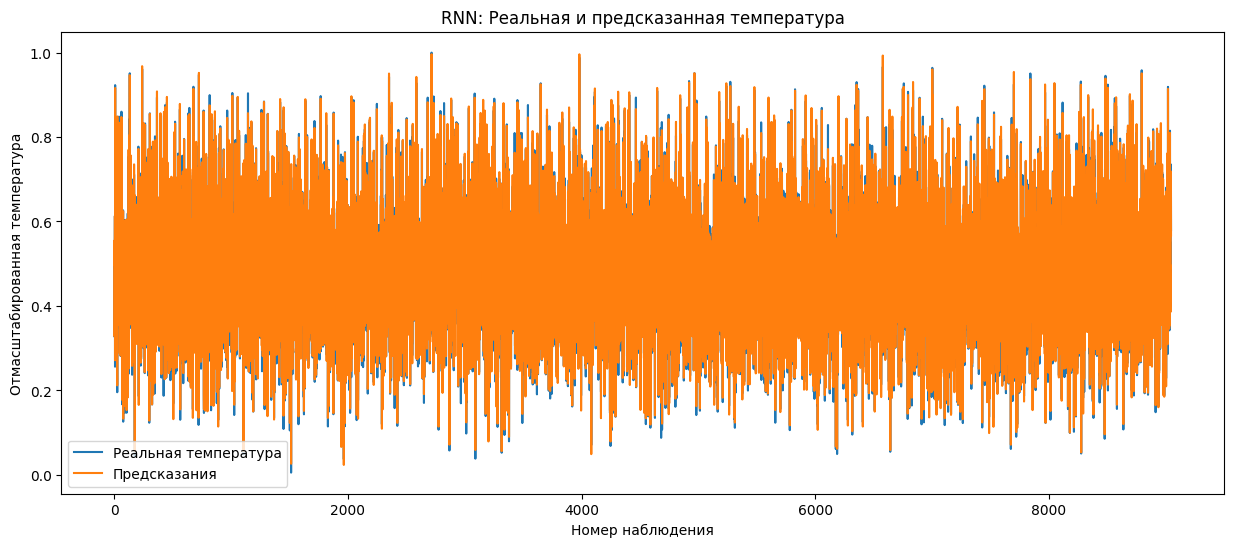

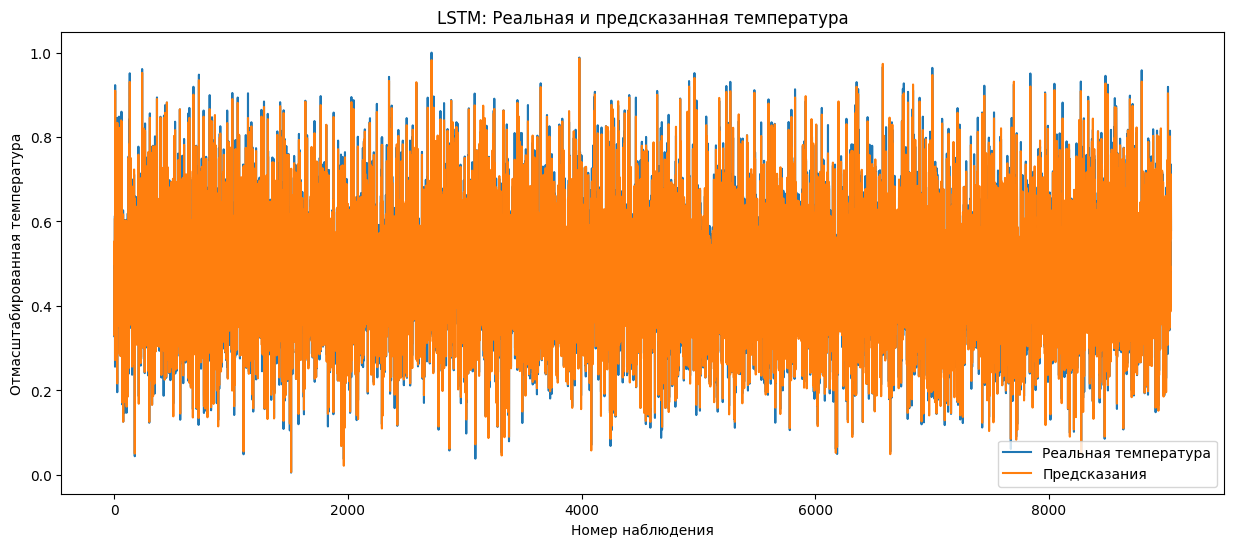

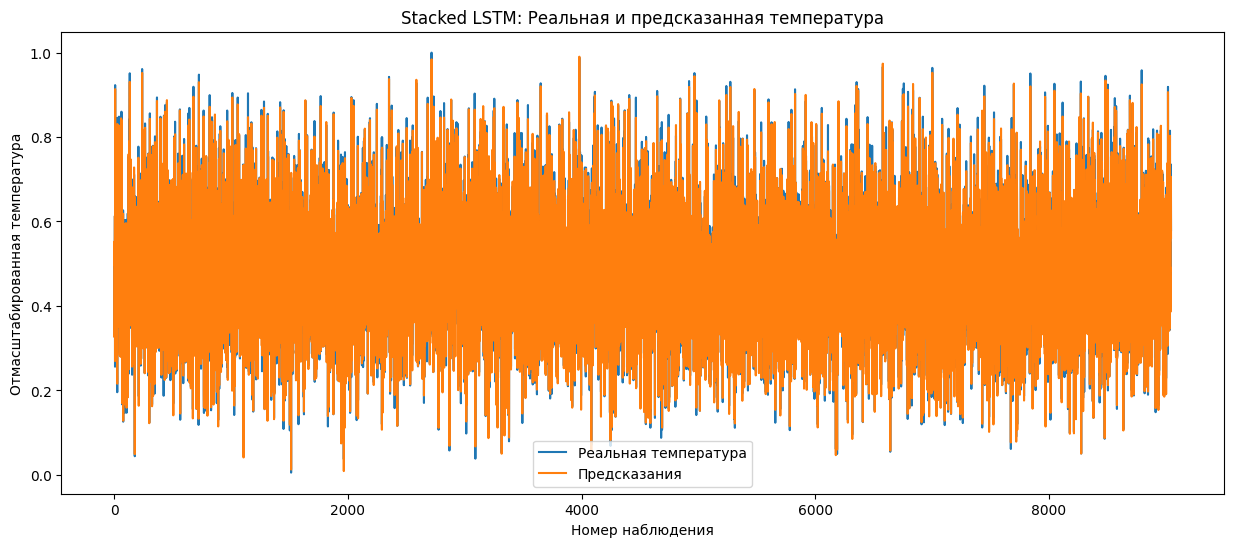

In [13]:
plot_result(y_test, test_predict_rnn, 'RNN: Реальная и предсказанная температура')
plot_result(y_test, test_predict_lstm, 'LSTM: Реальная и предсказанная температура')
plot_result(y_test, test_predict_stacked_lstm, 'Stacked LSTM: Реальная и предсказанная температура')
